In [ ]:
import polars as pl

# Load dataset
df = pl.read_csv("2024_fb_ads_president_scored_anon.csv")

# Deduplicate columns if needed
seen = set()
deduped_cols = [col for col in df.columns if not (col in seen or seen.add(col))]
df = df.select([pl.col(c) for c in deduped_cols])

# Numeric Summary
numeric_df = df.select(pl.col(pl.Float64, pl.Int64))
numeric_summary = numeric_df.describe()
numeric_summary.write_csv("fb_ads_numeric_summary.csv")

# Non-Numeric Summary 
non_numeric_df = df.select(pl.col(pl.Utf8))

non_numeric_rows = []
for col in non_numeric_df.columns:
    unique_count = df.select(pl.col(col).n_unique()).item()
    vc = df.select(pl.col(col).value_counts()).unnest(col)
    
    if vc.height > 0:
        most_common_val = vc[0, col]
        most_common_count = vc[0, "count"]
    else:
        most_common_val = None
        most_common_count = 0

    non_numeric_rows.append({
        "column": col,
        "unique_values": unique_count,
        "most_frequent_value": most_common_val,
        "frequency": most_common_count
    })

# Save non-numeric summary
pl.DataFrame(non_numeric_rows).write_csv("fb_ads_non_numeric_summary.csv")

# Grouped by page_id 
grouped_by_page = pl.DataFrame()
if 'page_id' in df.columns and 'estimated_spend' in df.columns:
    grouped_by_page = df.group_by("page_id").agg([
        pl.len().alias("ad_count"),
        pl.col("estimated_spend").mean().alias("avg_spend"),
        pl.col("estimated_spend").min().alias("min_spend"),
        pl.col("estimated_spend").max().alias("max_spend")
    ])
    grouped_by_page.write_csv("fb_ads_grouped_by_page_id.csv")

#  Grouped by page_id and ad_id 
grouped_by_page_ad = pl.DataFrame()
if all(col in df.columns for col in ['page_id', 'ad_id', 'estimated_spend']):
    grouped_by_page_ad = df.group_by(["page_id", "ad_id"]).agg([
        pl.len().alias("ad_count"),
        pl.col("estimated_spend").mean().alias("avg_spend"),
        pl.col("estimated_spend").min().alias("min_spend"),
        pl.col("estimated_spend").max().alias("max_spend")
    ])
    grouped_by_page_ad.write_csv("fb_ads_grouped_by_page_id_ad_id.csv")

print("✅ All summary files saved.")


✅ All summary files saved.


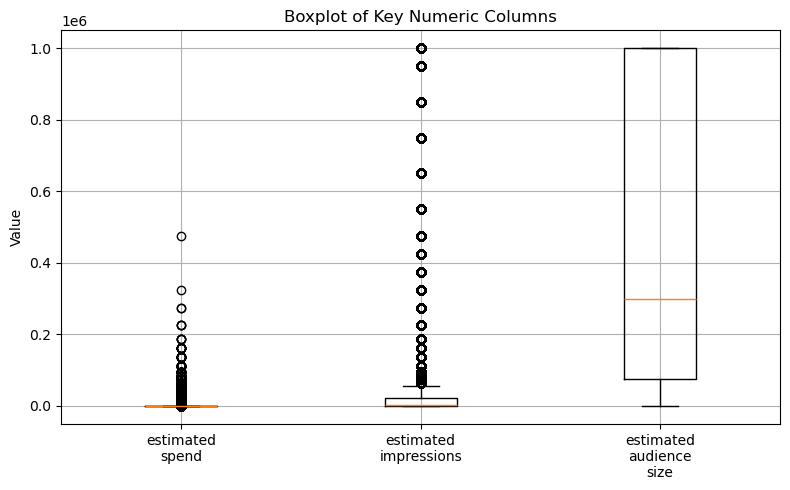

In [ ]:
import polars as pl
import matplotlib.pyplot as plt
# Load numeric summary 
data = pl.read_csv("2024_fb_ads_president_scored_anon.csv")
columns_to_plot = ["estimated_spend", "estimated_impressions", "estimated_audience_size"]
data = data.select([pl.col(col).cast(pl.Float64) for col in columns_to_plot])
clean_data = data.drop_nulls()
plot_data = {col: clean_data[col].to_list() for col in columns_to_plot}
#Boxplots
plt.figure(figsize=(8, 5))
plt.boxplot([plot_data[col] for col in columns_to_plot], labels=[col.replace("_", "\n") for col in columns_to_plot])
plt.title("Boxplot of Key Numeric Columns")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.savefig("polars_boxplot_fb_ads.png")
plt.show()